# Importações, carregamento e tratamento dos dados

## Importações e carregamento dos dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [82]:
import numpy as np
import pandas as pd
import os
import re
import joblib
import matplotlib.pyplot as plt # Gráficos
import seaborn as sns # Gráficos
from tqdm.notebook import tqdm # Barras de Progresso

In [83]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [84]:
X = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/normal_dataset.csv")

X_drop = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/drop_1.csv")
X_delay = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/delay_1.csv")
X_outOfSequence = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/outOfSequence_1.csv")

In [85]:
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)

## Tratamento dos dados

In [107]:
# Remover as colunas que não vamos usar e criar a coluna de Label nos dados de validação e teste

for X in [X_drop, X_delay, X_outOfSequence]:
  X.drop(columns=[col for col in X.columns if col not in ['Time', 'Length']], inplace=True)
  X['Label'] = 0.0

In [108]:
# Rotulação dos dados em benignos (0.0) e malignos (1.0)

Xs = [X_drop, X_delay, X_outOfSequence]

for j in range(len(Xs)):
  suspicious_indexes = Xs[j][(0.000124 > Xs[j]['Time']) | (Xs[j]['Time'] > 0.000126)].index

  for idx in suspicious_indexes:
    if (idx - 1) > -1:
      if Xs[j].iloc[idx-1, X.columns.get_loc('Length')] == 66 and Xs[j].iloc[idx, X.columns.get_loc('Length')] == 66:
        Xs[j].loc[idx, 'Label'] = 1.0

In [109]:
# Selecionando as colunas que vamos utilizar no treinamento

X = X[['Time', 'Length']]

In [110]:
# Separando os dados dos rótulos

y_drop, X_drop = X_drop['Label'], X_drop.drop(columns=['Label'])
y_delay, X_delay = X_delay['Label'], X_delay.drop(columns=['Label'])
y_outOfSequence, X_outOfSequence = X_outOfSequence['Label'], X_outOfSequence.drop(columns=['Label'])

# Definindo Modelos

## Isolation Forest

In [130]:
# Normalização dos dados

scaler_if = StandardScaler()
X_if = scaler_if.fit_transform(X)

X_drop_if = scaler_if.transform(X_drop)

In [134]:
# Definindo os hiperparâmetros a serem testados

model_if = IsolationForest(random_state=RANDOM_SEED)

param_dist = {
    'n_estimators': [50, 100, 300, 450],
    'max_samples': [.92, .95, .98, .99, 1.0],
    'contamination': [.06, .08, .45, .5, .55, .6]
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator = model_if,
    param_distributions = param_dist,
    n_iter = 40,
    cv = 4,
    scoring = "accuracy",
    random_state = RANDOM_SEED
)

random_search.fit(X_drop_if[:150000], y_drop[:150000])

In [137]:
print("Best parameters found: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 300, 'max_samples': 0.92, 'contamination': 0.06}
Best score:  0.03272666666666667


In [141]:
N_ESTIMATORS = 300

model_if = IsolationForest(
    n_estimators=random_search.best_params_['n_estimators'],
    max_samples=random_search.best_params_['max_samples'],
    contamination=random_search.best_params_['contamination'],
    random_state=RANDOM_SEED
)

model_if.fit(X_if)

IsolationForest(contamination=0.06, max_samples=0.92, n_estimators=300,
                random_state=33)

In [149]:
from pickle import dump
with open("if41.pkl", "wb") as f:
    dump(model_if, f, protocol=5)

with open("scaler_if41", "wb") as f:
    dump(scaler_if, f, protocol=5)

## Autoencoder LSTM

In [111]:
# Normalização dos dados

scaler_alstm = MinMaxScaler()
X_alstm = scaler_alstm.fit_transform(X)

X_drop_alstm = scaler_alstm.transform(X_drop)

In [112]:
def create_sequences(data, steps):
  sequences = []
  for i in range(len(data) - steps):
    sequences.append(data[i:i+steps])

  return np.array(sequences)

In [113]:
# Criando as sequências

timesteps = 2
X_alstm = create_sequences(X_alstm, timesteps)

In [114]:
model_alstm = Sequential()

model_alstm.add(LSTM(128, activation='relu', input_shape=(timesteps, X_alstm.shape[2]), return_sequences=True))
model_alstm.add(Dropout(0.2))
model_alstm.add(LSTM(64, activation='relu', return_sequences=False))

model_alstm.add(RepeatVector(timesteps))

model_alstm.add(LSTM(64, activation='relu', return_sequences=True))
model_alstm.add(LSTM(128, activation='relu', return_sequences=True))
model_alstm.add(Dropout(0.2))

model_alstm.add(TimeDistributed(Dense(X_alstm.shape[2])))

In [ ]:
model_alstm.compile(optimizer='adam', loss='mse')
model_alstm.summary()

In [116]:
model_alstm.fit(X_alstm, X_alstm, epochs=20, batch_size=32, validation_split=.05, shuffle=False)

Epoch 1/20
21561/21561 [==============================] - 291s 13ms/step - loss: 7.0450e-04 - val_loss: 2.4081e-05
Epoch 2/20
21561/21561 [==============================] - 285s 13ms/step - loss: 5.4283e-05 - val_loss: 1.6673e-05
Epoch 3/20
21561/21561 [==============================] - 283s 13ms/step - loss: 4.2904e-05 - val_loss: 1.3481e-05
Epoch 4/20
21561/21561 [==============================] - 284s 13ms/step - loss: 3.7179e-05 - val_loss: 8.6327e-06
Epoch 5/20
21561/21561 [==============================] - 278s 13ms/step - loss: 3.5148e-05 - val_loss: 1.2350e-05
Epoch 6/20
21561/21561 [==============================] - 272s 13ms/step - loss: 3.2906e-05 - val_loss: 6.4724e-06
Epoch 7/20
21561/21561 [==============================] - 261s 12ms/step - loss: 3.1148e-05 - val_loss: 5.6640e-06
Epoch 8/20
21561/21561 [==============================] - 269s 12ms/step - loss: 2.8789e-05 - val_loss: 4.5478e-06
Epoch 9/20
21561/21561 [==============================] - 261s 12ms/step - loss:

In [117]:
from pickle import dump
with open("alstm41.pkl", "wb") as f:
    dump(model_alstm, f, protocol=5)

with open("scaler_alstm41", "wb") as f:
    dump(scaler_alstm, f, protocol=5)

## KMeans

In [ ]:
# Normalização dos dados

scaler_kmeans = StandardScaler()
X_kmeans = scaler_kmeans.fit_transform(X)

X_drop_kmeans = scaler_kmeans.transform(X_drop)

In [ ]:
# Criamos um subconjunto com 2% dos dados de treinamento

subset_train_size = int(X_kmeans.shape[0]*0.02)
train_indexes = [i for i in range(subset_train_size)]
X_subset = X_kmeans[train_indexes,:]

In [ ]:
# Analisamos a pontuação obtida na métrica silhouette score para os clusters formados para diferentes valores de K

k_list = list(range(2, 21))
silhouette_score_list = []

for k in tqdm(k_list):
    model_kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=30)
    model_kmeans = model_kmeans.fit(X_subset)

    s_score = silhouette_score(X_subset, model_kmeans.predict(X_subset))
    silhouette_score_list.append(s_score)

  0%|          | 0/19 [00:00<?, ?it/s]

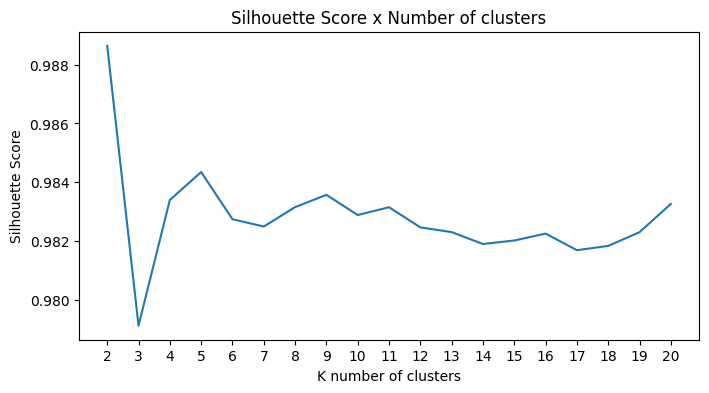

In [ ]:
### Não é preciso entender de verdade, é só para plotar o gráfico

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('K number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_xticks(k_list)
ax.set_title('Silhouette Score x Number of clusters')
ax.plot(k_list, silhouette_score_list)

In [ ]:
# Definição e treinamento do modelo Kmeans

K_CLUSTERS = 2
model_kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_SEED, n_init=30)
model_kmeans = model_kmeans.fit(X_kmeans)

### Análise PCA

In [ ]:
# Análise PCA

def plot_pca(X, model_kmeans=None, print_centroids = False):
  pca = PCA(n_components=2, random_state=RANDOM_SEED) # Reduziremos a dimensionalidade dos dados para 2
  X_pca = pca.fit_transform(X)


  fig, ax = plt.subplots(figsize=(8, 4))
  ax.set_title('PCA Analysis')

  if print_centroids and model_kmeans is not None:
    cluster_centers_principal_components = pca.transform(model_kmeans.cluster_centers_)
    num_clusters = cluster_centers_principal_components.shape[0]
    X_clusters = model_kmeans.predict(X)

    for cluster in range(num_clusters):
      indexes = np.where(X_clusters == cluster)
      ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')

    for i, cluster_center_pc in enumerate(cluster_centers_principal_components):
      ax.scatter(cluster_center_pc[0], cluster_center_pc[1], c='black', s=8, marker='x')
      ax.annotate(f'Cluster#{i}', (cluster_center_pc[0], cluster_center_pc[1]), size=10)
    ax.legend()

  else:
    ax.scatter(X_pca[:,0], X_pca[:,1], s=1)

<ipython-input-78-96a2e3218ae7>:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')


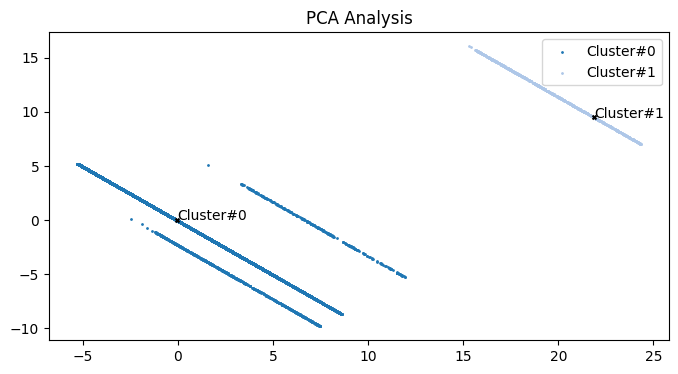

In [ ]:
plot_pca(X_kmeans, model_kmeans, print_centroids=True)

# Avaliando Modelos

## Definindo um threshold e avaliando resultados (funções)

In [122]:
# Função para plotar a curva ROC

def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)

  ## Configurações do gráfico
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [123]:
# Função para calcular a taxa de vedadeiros positivos por ataque

def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})

  total_per_label = aux_df['Label'].value_counts().to_dict()

  correct_predictions_per_label = aux_df.query('Label != 0 and prediction == True').groupby('Label').size().to_dict()

  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 0: # Pula se for benigno
      continue

    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr

  return tpr_per_attack

In [124]:
# Função para calcular métricas gerais

def get_overall_metrics(y_true, y_pred):
  ## tn (verdadeiros negativos), fp (falsos positivos), fn (falsos negativos), tp (verdadeiros positivos)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  acc = (tp+tn)/(tp+tn+fp+fn) ## Cálculo da acurácia (proporção de amostras classificadas corretamente)

  tpr = tp/(tp+fn) ## Cálculo da taxa de verdadeiros positivos
  fpr = fp/(fp+tn) ## Cálculo da taxa de falsos positivos

  precision = tp/(tp+fp) ## Cálculo da precisão (proporção dos verdadeiros positivos dentre todos os positivos obtidos)
  f1 = (2*tpr*precision)/(tpr+precision) ## Cálculo do f1-score (média harmonica entre a precisão e o recall)

  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [125]:
# Função para plotar a matrix de confusão

def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

## Autoencoder LSTM

In [118]:
X_test_alstm, y_alstm = create_sequences(X_drop_alstm, timesteps), y_drop

In [119]:
reconstructions = model_alstm.predict(X_test_alstm)
mse = np.mean(np.power(X_test_alstm - reconstructions, 2), axis=(1, 2))

22773/22773 [==============================] - 101s 4ms/step


In [120]:
threshold = np.percentile(mse, 91.999)
anomalies = mse > threshold

print(f"Anomalias totais: {(y_alstm == 1.0).sum()} - Anoomalias detectadas: {np.sum(anomalies)}")

Anomalias totais: 54023 - Anoomalias detectadas: 58306


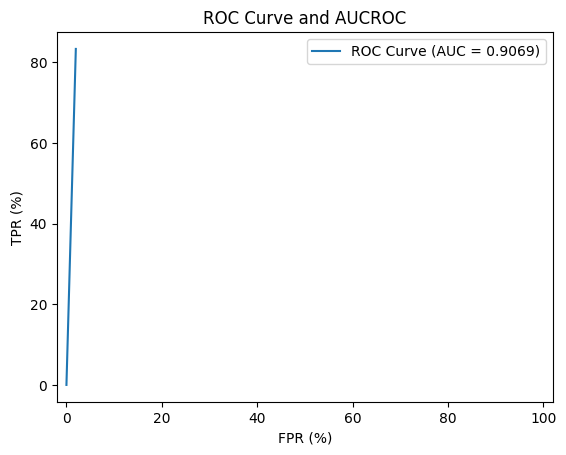

In [126]:
plot_roc_curve(y_alstm[:-timesteps], anomalies, max_fpr=1.0)

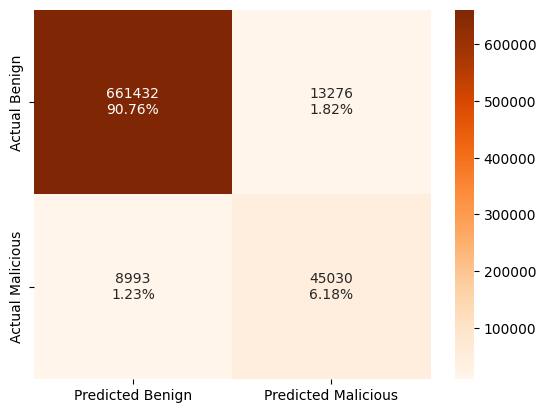

In [127]:
plot_confusion_matrix(y_alstm[:-timesteps], anomalies)

In [128]:
get_overall_metrics(y_alstm[:-timesteps], anomalies)

{'acc': 0.9694413988152006,
 'tpr': 0.8335338652055606,
 'fpr': 0.019676660125565428,
 'precision': 0.7723047370768017,
 'f1-score': 0.8017519963678124}

## Kmeans

In [ ]:
X_test_kmeans, y_kmeans = X_drop_kmeans, y_drop

In [ ]:
val_centroids_distances_kmeans = model_kmeans.transform(X_test_kmeans)
val_centroids_distances_kmeans = model_kmeans.transform(X_test_kmeans)
val_anomaly_scores_kmeans = np.min(val_centroids_distances_kmeans, axis=1)

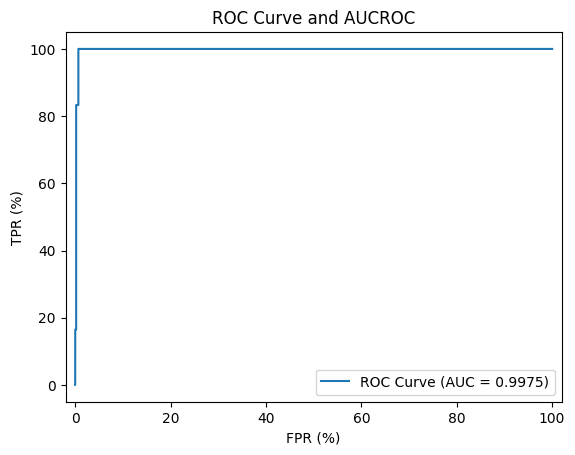

In [ ]:
plot_roc_curve(y_kmeans, val_anomaly_scores_kmeans)

In [ ]:
# Calculamos a taxa de falsos positivos, taxa de verdadeiros positivos, o threshold e o índice de Youden

fpr_kmeans, tpr_kmeans, thresholds_kmeans = roc_curve(y_kmeans, val_anomaly_scores_kmeans)
df_val_roc_kmeans = pd.DataFrame({'fpr':fpr_kmeans, 'tpr':tpr_kmeans, 'thresholds':thresholds_kmeans})

df_val_roc_kmeans['youden-index'] = df_val_roc_kmeans['tpr'] - df_val_roc_kmeans['fpr']
df_val_roc_kmeans.sort_values('youden-index', ascending=False).drop_duplicates('fpr')[:3] # Limiar ótimo é o 1°

,fpr,tpr,thresholds,youden-index
338,0.006670,1.0,2.649069,0.993330
339,0.006745,1.0,2.480118,0.993255
340,0.006748,1.0,2.475395,0.993252


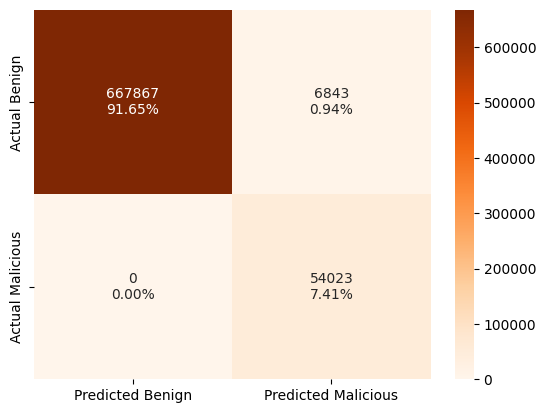

In [ ]:
BEST_VALIDATION_THRESHOLD_kmeans = 0.059399
plot_confusion_matrix(y_kmeans, val_anomaly_scores_kmeans > BEST_VALIDATION_THRESHOLD_kmeans)

In [ ]:
get_overall_metrics(y_kmeans, val_anomaly_scores_kmeans > BEST_VALIDATION_THRESHOLD_kmeans)

{'acc': 0.9906097294894015,
 'tpr': 1.0,
 'fpr': 0.010142135139541432,
 'precision': 0.8875727006867545,
 'f1-score': 0.9404381620520678}

## Isolation Forest

In [142]:
X_test_if, y_if = X_drop_if, y_drop

In [143]:
val_scores_iforest = model_if.score_samples(X_test_if)
val_scores_iforest = np.abs(val_scores_iforest)

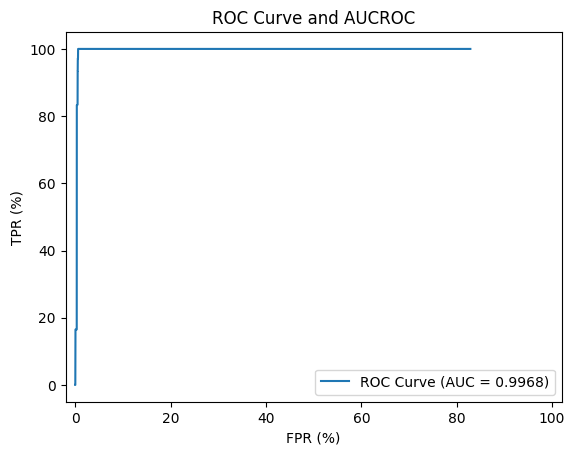

In [144]:
plot_roc_curve(y_drop, val_scores_iforest)

In [146]:
fpr, tpr, thresholds = roc_curve(y_drop, val_scores_iforest)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False)[:3].drop_duplicates('fpr')

,fpr,tpr,thresholds,youden-index
490,0.005899,1.0,0.537917,0.994101
491,0.005915,1.0,0.536245,0.994085
492,0.005918,1.0,0.536243,0.994082


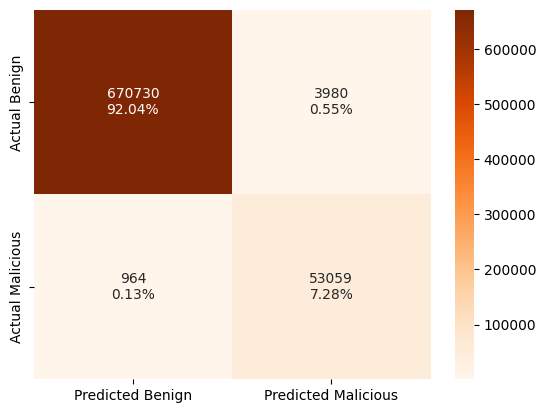

In [147]:
BEST_IFOREST_VALIDATION_THRESHOLD = 0.537917
plot_confusion_matrix(y_drop, val_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

In [148]:
get_overall_metrics(y_drop, val_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

{'acc': 0.9932156221826101,
 'tpr': 0.9821557484775003,
 'fpr': 0.005898830608705962,
 'precision': 0.9302231806307965,
 'f1-score': 0.9554843240712395}